In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import random
import time
import glob
from tqdm import tqdm

In [4]:
# Define the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


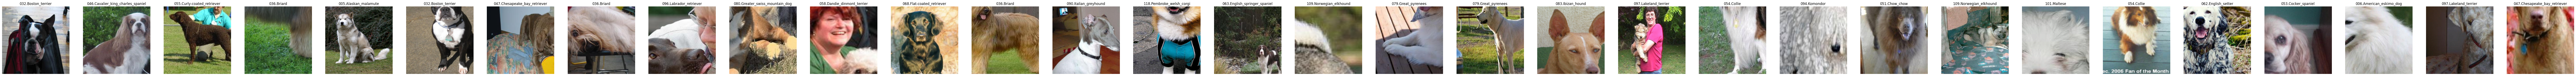

In [68]:
#set the batch size
batch_size = 32

#Data path
imagePath = '/home/melson/DeepL/dogImages/'

#Data transformation

data_transforms_dict = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'valid': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'test': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'prediction': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

#load data
image_datasets = {x: datasets.ImageFolder(os.path.join(imagePath, x), data_transforms_dict[x]) 
                  for x in ['train', 'valid', 'test']}

#Dataloader
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'valid', 'test']
}

# Get a batch of training data
inputs, classes = next(iter(loaders_scratch['train']))
classes_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

num_images = len(inputs)  # 获取图像数量
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # 创建一个 subplot 行，每个图像一个 subplot

for i, (image, label) in enumerate(zip(inputs, classes)):
    image = image.to("cpu").clone().detach()  # 将图像移动到 CPU
    image = image.numpy().squeeze()  # 转换为 NumPy 数组并去掉不必要的维度
    image = image.transpose(1, 2, 0)  # 转置维度以适应 matplotlib 的显示格式
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # 反归一化
    image = image.clip(0, 1)  # 限制图像值在 0 到 1 之间

    ax = axes[i] if num_images > 1 else axes  # 获取当前 subplot 的轴对象
    ax.imshow(image)  # 在当前轴上显示图像
    ax.set_title(classes_names[label])  # 设置标题为类别名称
    ax.axis('off')  # 关闭坐标轴显示

plt.show()  # 显示整个图形


In [6]:
try:
    ImageFile.LOAD_TRUNCATED_IMAGES = True
except:
    pass


def train_model(n_epochs, loaders, model, optimizer, scheduler, criterion, device, save_path):

    scheduler = scheduler
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    learning_rate_history = []

    best_acc = 0.0
    for epoch in range(1, n_epochs + 1):
        print('-' * 10)
        print(f'Epoch {epoch }/{n_epochs}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #iterate over data
            for data, target in loaders[phase]:
                data, target = data.to(device), target.to(device)
                #zero the parameter gradients
                optimizer.zero_grad()

                #forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = criterion(output, target)
                    _, preds = torch.max(output, 1)
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == target.data)

            if phase == 'train':
                scheduler.step()
            # epoch_loss = np.mean(running_loss)
            # epoch_acc = np.mean(running_corrects)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc.cpu().numpy()
            else:
                valid_loss = epoch_loss
                valid_acc = epoch_acc.cpu().numpy()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print("Current learning rate; ", optimizer.param_groups[0]['lr'])

        
        #save the model if validation loss has decreased
        if phase == 'valid' and epoch_acc >= best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
        
        
                    
        # Append histories after converting to normal Python types or ensuring they are on CPU
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_acc)
        valid_acc_history.append(valid_acc)
        learning_rate_history.append(optimizer.param_groups[0]['lr'])

    #save the model_metrics    
    model_metrics = {
        'train_loss_history': train_loss_history,
        'valid_loss_history': valid_loss_history,
        'train_acc_history': train_acc_history,
        'valid_acc_history': valid_acc_history,
        'learning_rate_history': learning_rate_history
    }
    return model, model_metrics

def plotting(input_metric, input_metric_name):
    
    
    fig, arg = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(input_metric_name, fontsize=16)
    # Plot for Learning Rate
    arg[0].plot(np.array(input_metric['learning_rate_history']), label='learning rate')
    arg[0].set_title('Learning Rate')
    arg[0].set_xlabel('Epoch')

    # Plot for loss
    arg[1].plot(np.array(input_metric['train_loss_history']), label='Training Loss')
    arg[1].plot(np.array(input_metric['valid_loss_history']), label='Validation Loss')
    arg[1].set_title('Loss')
    arg[1].set_xlabel('Epoch')
    arg[1].set_ylabel('loss')
    arg[1].legend()

    # Plot for accuracy
    arg[2].plot(np.array(input_metric['train_acc_history']), label='Training Accuracy')
    arg[2].plot(np.array(input_metric['valid_acc_history']), label='Validation Accuracy')
    arg[2].set_title('Accuracy')
    arg[2].set_xlabel('Epoch')
    arg[2].set_ylabel('acc')
    arg[2].legend()

    plt.show()

def load_model(model_path, model, device):
    """
    Load the trained model from a file.
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model


def test_model(model_path, model, criterion, test_loader, device, show_images=False, images_per_figure=10):
    """
    Test the trained model with the provided test loader and optionally display images.
    """
    model = load_model(model_path, model, device)
    model.eval()  # Set model to evaluation mode
    
    test_loss = 0.0
    all_preds = []
    all_targets = []
    class_names = classes_names

    # Initialize for image display
    if show_images:
        fig, axes = None, None
        current_image_count = 0

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            if show_images:
                # Prepare to display images
                if current_image_count % images_per_figure == 0:
                    if fig is not None:
                        plt.tight_layout()
                        plt.show()
                    # Calculate columns needed for the current set of images
                    num_images_remaining = len(test_loader.dataset) - current_image_count
                    cols = min(images_per_figure, num_images_remaining)
                    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols * 2, 2))  # Adjusted figsize
                    if cols == 1:
                        axes = [axes]  # Ensure axes is iterable
                    
                ax = axes[current_image_count % images_per_figure]

                image = data.cpu().data[0].permute(1, 2, 0).numpy()
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                image = np.clip(image, 0, 1)
                ax.imshow(image)
                ax.set_title(f'Predicted: {class_names[preds[0]]}')
                ax.axis('off')
                current_image_count += 1

    if show_images and fig is not None:
        plt.tight_layout()
        plt.show()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_targets))

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    test_metrics = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

    return test_metrics

def plot_confusion_matrix(model_metric, class_names, model_name):
    """
    Plot the confusion matrix using seaborn and matplotlib.
    """
    plt.figure(figsize=(5, 4))
    sns.heatmap(model_metric['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('From %s (Acc: %.4f%%)' % (model_name, model_metric['accuracy']*100))
    plt.show()

In [40]:
class DogBreedResNet(nn.Module):
    def __init__(self, num_classes):
        super(DogBreedResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)

        return out

class DogBreedResNetFeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(DogBreedResNetFeatureExtractor, self).__init__()
        # Keep all parts of the pretrained model except the final fully connected layer
        self.features = nn.Sequential(
            *list(pretrained_model.children())[:-1]  # Remove the last layer
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features into a vector
        return x
    


class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        self.dog_breed_resnet = DogBreedResNet(num_classes)
        

        self.resnet18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)


        # Classifier to combine features
        # Assuming each network outputs 512 features
        # self.classifier = nn.Linear(133 + 133, num_classes)
        self.combined_features_size = 133 + 133  # Adjust accordingly if different
        self.classifier = nn.Sequential(
            nn.Linear(self.combined_features_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        features1 = self.dog_breed_resnet(x)
        features2 = self.resnet18(x)
        
        # Concatenate features along the feature dimension
        combined_features = torch.cat((features1, features2), dim=1)
        
        # Pass the combined features through the final classifier
        output = self.classifier(combined_features)
        return output

In [69]:
Dawg = DogBreedResNet(num_classes=133)
# for param in Dawg.parameters():
#     param.requires_grad = False
# Dawg.fc = nn.Linear(512, 133)
Dawg.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Dawg.parameters(), lr = 5e-3, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

num_epoch = 100
# Train the model
print("Start Training model from scratch")
model_scratch, metric_scratch = train_model(num_epoch, loaders_scratch, Dawg, optimizer, scheduler, criterion, device, 'Dawg_batchsize32.pt')

Start Training model from scratch
----------
Epoch 1/100
train Loss: 4.4717 Acc: 0.0415
valid Loss: 4.7632 Acc: 0.0287
Current learning rate;  0.005
----------
Epoch 2/100
train Loss: 4.1470 Acc: 0.0745
valid Loss: 4.7619 Acc: 0.0311
Current learning rate;  0.005
----------
Epoch 3/100
train Loss: 3.9569 Acc: 0.0973
valid Loss: 4.6090 Acc: 0.0527
Current learning rate;  0.005
----------
Epoch 4/100
train Loss: 3.8306 Acc: 0.1191
valid Loss: 4.4171 Acc: 0.0647
Current learning rate;  0.005
----------
Epoch 5/100
train Loss: 3.7500 Acc: 0.1293
valid Loss: 4.6848 Acc: 0.0575
Current learning rate;  0.005
----------
Epoch 6/100
train Loss: 3.6852 Acc: 0.1430
valid Loss: 4.1973 Acc: 0.0790
Current learning rate;  0.005
----------
Epoch 7/100
train Loss: 3.6386 Acc: 0.1510
valid Loss: 4.1449 Acc: 0.0766
Current learning rate;  0.005
----------
Epoch 8/100
train Loss: 3.5968 Acc: 0.1592
valid Loss: 4.8982 Acc: 0.0491
Current learning rate;  0.005
----------
Epoch 9/100
train Loss: 3.5544 Acc:

KeyboardInterrupt: 

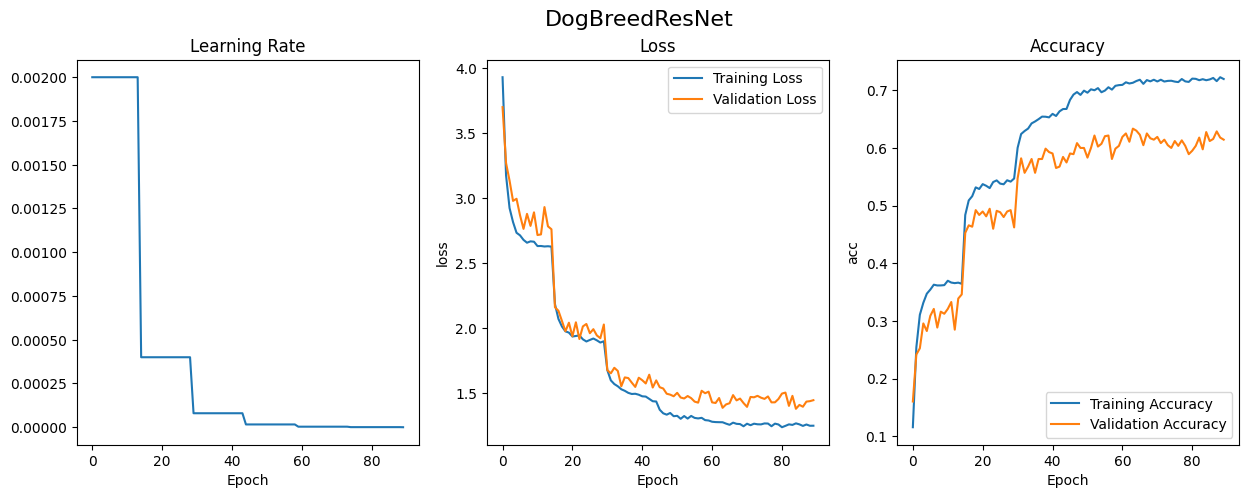

In [20]:
plotting(metric_scratch, 'DogBreedResNet')

In [25]:
Dawg = DogBreedResNet(133)
load_model('/home/melson/DeepL/Final/examples/Dawg_batchsize16.pt', Dawg, device)
test = test_model('/home/melson/DeepL/Final/examples/Dawg_batchsize16.pt', Dawg,criterion, loaders_scratch['test'], device, False)
print('test loss: %f, accuracy: %.3f%%' % (test['test_loss'], test['accuracy']*100) )

test loss: 1.422543, accuracy: 61.722%


# Ensemble Learning with resnet18

In [59]:
num_classes = 133
new_dawg = HybridModel(num_classes=133)
state_dict = torch.load('/home/melson/DeepL/Final/examples/Dawg_batchsize16.pt')
new_dawg.dog_breed_resnet.load_state_dict(state_dict)
# for param in new_dawg.dog_breed_resnet.parameters():
#     param.requires_grad = False
new_dawg.dog_breed_resnet.fc = nn.Linear(512, num_classes)

# for param in new_dawg.resnet18.parameters():
#     param.requires_grad = False
new_dawg.resnet18.fc = nn.Linear(512, num_classes)            
new_dawg.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_dawg.parameters(), lr = 2e-3, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

num_epoch = 50
# Train the model
print("Start Training model from scratch")
model_scratch, metric_scratch = train_model(num_epoch, loaders_scratch, new_dawg, optimizer, scheduler, criterion, device, '/home/melson/DeepL/Final/model_pt/hybrid_3.pt')


Start Training model from scratch
----------
Epoch 1/50
train Loss: 3.0553 Acc: 0.2941
valid Loss: 2.2822 Acc: 0.3760
Current learning rate;  0.002
----------
Epoch 2/50
train Loss: 2.1733 Acc: 0.4313
valid Loss: 2.1924 Acc: 0.4108
Current learning rate;  0.002
----------
Epoch 3/50
train Loss: 2.1724 Acc: 0.4329
valid Loss: 2.3311 Acc: 0.3880
Current learning rate;  0.002
----------
Epoch 4/50
train Loss: 2.2805 Acc: 0.4134
valid Loss: 2.2841 Acc: 0.3856
Current learning rate;  0.002
----------
Epoch 5/50
train Loss: 2.3424 Acc: 0.4019
valid Loss: 2.5833 Acc: 0.3497
Current learning rate;  0.001
----------
Epoch 6/50
train Loss: 2.0787 Acc: 0.4683
valid Loss: 1.9332 Acc: 0.4647
Current learning rate;  0.001
----------
Epoch 7/50
train Loss: 2.0370 Acc: 0.4783
valid Loss: 1.9399 Acc: 0.4611
Current learning rate;  0.001
----------
Epoch 8/50
train Loss: 2.0674 Acc: 0.4714
valid Loss: 2.0663 Acc: 0.4467
Current learning rate;  0.001
----------
Epoch 9/50
train Loss: 2.1191 Acc: 0.4568
v

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f707ff536d0>
Traceback (most recent call last):
  File "/home/melson/miniconda3/envs/melson/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/melson/miniconda3/envs/melson/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/melson/miniconda3/envs/melson/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f707ff536d0>
Traceback (most recent call last):
  File "/home/melson/miniconda3/envs/melson/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/melson/miniconda3/envs/melson/l

train Loss: 0.9991 Acc: 0.7648
valid Loss: 1.1202 Acc: 0.6850
Current learning rate;  3.90625e-06
----------
Epoch 48/50
train Loss: 0.9842 Acc: 0.7624
valid Loss: 1.0909 Acc: 0.6862
Current learning rate;  3.90625e-06
----------
Epoch 49/50
train Loss: 0.9891 Acc: 0.7624
valid Loss: 1.1816 Acc: 0.6671
Current learning rate;  3.90625e-06
----------
Epoch 50/50
train Loss: 0.9894 Acc: 0.7625
valid Loss: 1.1339 Acc: 0.6707
Current learning rate;  1.953125e-06


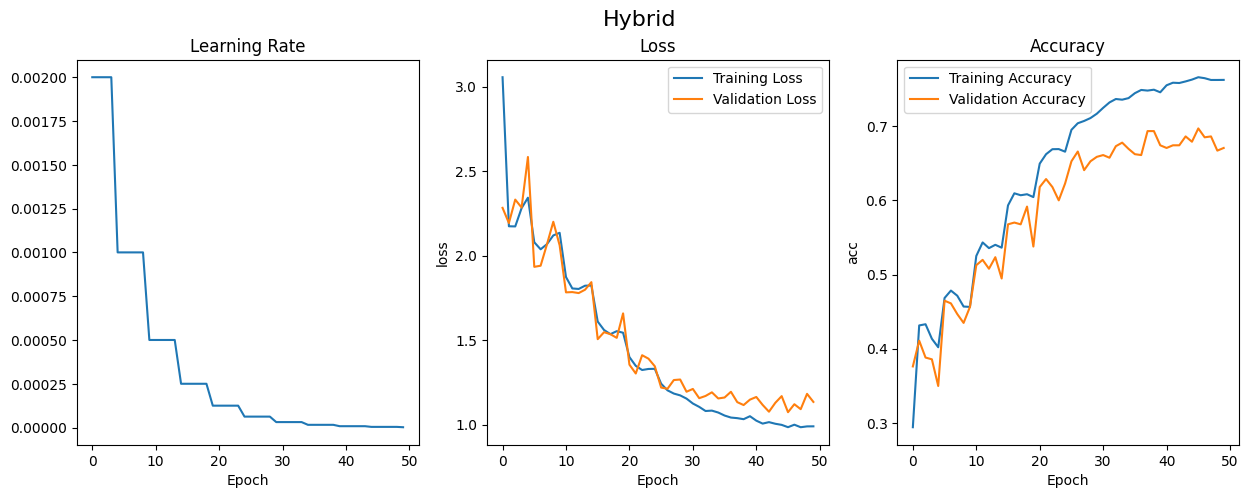

In [60]:
plotting(metric_scratch, 'Hybrid')

In [61]:
new_dawg = HybridModel(133)
# for param in new_dawg.resnet18.parameters():
#     param.requires_grad = False
new_dawg.resnet18.fc = nn.Linear(512, num_classes) 
state_dict = torch.load('/home/melson/DeepL/Final/model_pt/hybrid_3.pt')
new_dawg.load_state_dict(state_dict)
new_dawg.to(device)
test = test_model('/home/melson/DeepL/Final/model_pt/hybrid_3.pt', new_dawg, criterion, loaders_scratch['test'], device, False)
print('test loss: %f, accuracy: %.3f%%' % (test['test_loss'], test['accuracy']*100) )

test loss: 1.110449, accuracy: 68.660%


In [67]:
new_dawg = HybridModel(num_classes=133)
new_dawg.resnet18.fc = nn.Linear(512, num_classes) 
state_dict = torch.load('/home/melson/DeepL/Final/model_pt/hybrid_fixed.pt')
new_dawg.load_state_dict(state_dict)

for param in new_dawg.dog_breed_resnet.parameters():
    param.requires_grad = False
new_dawg.dog_breed_resnet.fc = nn.Linear(512, num_classes)
new_dawg.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_dawg.parameters(), lr = 2e-3, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

num_epoch = 200
# Train the model
print("Start Training model from scratch")
model_scratch, metric_scratch = train_model(num_epoch, loaders_scratch, new_dawg, optimizer, scheduler, criterion, device, '/home/melson/DeepL/Final/model_pt/hybrid_fixed.pt')


Start Training model from scratch
----------
Epoch 1/200
train Loss: 3.2671 Acc: 0.2278
valid Loss: 3.4169 Acc: 0.2048
Current learning rate;  0.002
----------
Epoch 2/200
train Loss: 2.8539 Acc: 0.2940
valid Loss: 2.9124 Acc: 0.2778
Current learning rate;  0.002
----------
Epoch 3/200
train Loss: 2.7824 Acc: 0.3058
valid Loss: 2.9800 Acc: 0.2754
Current learning rate;  0.002
----------
Epoch 4/200
train Loss: 2.7825 Acc: 0.3091
valid Loss: 3.0738 Acc: 0.2599
Current learning rate;  0.002
----------
Epoch 5/200
train Loss: 2.7520 Acc: 0.3175
valid Loss: 2.8189 Acc: 0.2731
Current learning rate;  0.0016
----------
Epoch 6/200
train Loss: 2.6504 Acc: 0.3355
valid Loss: 2.5585 Acc: 0.3353
Current learning rate;  0.0016
----------
Epoch 7/200
train Loss: 2.6394 Acc: 0.3375
valid Loss: 2.6527 Acc: 0.3018
Current learning rate;  0.0016
----------
Epoch 8/200
train Loss: 2.6203 Acc: 0.3389
valid Loss: 2.7209 Acc: 0.3150
Current learning rate;  0.0016
----------
Epoch 9/200
train Loss: 2.6144 

KeyboardInterrupt: 